## Analysis of Experimental Outcomes. Llama3.2-1B.

In this notebook, we inspect the outcomes of the speaker experiment (original experiment 2 in Achimova et al. 2025). The distribution of the indirect responses will be investigated following the original procedures from Achimova et al. (2025). That includes:

1. Initial inspection of the outcome distributions.
2. Investigating the effect of opinions match/mismatch on the proportions of indirect speech with respect to the conversational goals.
3. Investigating the effect of speaker's opinion on the proportions of indirect speech with respect to the conversational goals.

First, we load the experimental outcomes.

In [1]:
import json
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open("../../../../data/out/prompts_speaker_exp_Llama-3.2-1B.json", encoding="utf-8") as f:
    res = json.load(f)

In [3]:
res_real = res["real"]  # reproduction from real speakers
res_real_plain = res_real["plain"]
res_real_hearts = res_real["hearts"]
trials_plain, trials_hearts = [], []
for experiment_data_plain, experiment_data_hearts in zip(res_real_plain, res_real_hearts):
    trials_plain.extend(experiment_data_plain["trial_items"])
    trials_hearts.extend(experiment_data_hearts["trial_items"])


For each trial, we among other infos have the response probability distribution from the LM as well as the metadata of the trial, such as the polarity of the speaker's opinion and its match/mismatch with the listener's.

In [4]:
trials_plain[0]

{'prompt': 'Hint: The opinions will be written in a plain text, from "strongly negative" to "strongly positive". \n\nStart!\n===========================\n\nChristian wants to discuss the housing crisis with John.\nChristian feels strongly positive about the issue.\nChristian thinks that John feels strongly positive about it, but he is not sure.\n\nChristian wants to avoid possible conflicts. What would Christian say?\n\nA: The mayor\'s decision about the housing crisis is awful.\nB: The mayor\'s decision about the housing crisis is rather bad.\nC: The mayor\'s decision about the housing crisis is okay.\nD: The mayor\'s decision about the housing crisis is decent.\nE: The mayor\'s decision about the housing crisis is great.\n\n\n===========================\n\n\nYour answer is ',
 'metadata': {'match': True,
  'conversational_goal': 'social',
  'is_positive': True,
  'response': 5},
 'prob_distr': [0.2856429152058396,
  0.14594884029104857,
  0.25356185845659707,
  0.1735633993005108,
  

# Overall Inter-rater Agreement

First thing we do, we inspect the overall distribution of the ratings from the human participants and the LLM and to determine whether they come from the same distribution. For that, we apply the Chi-squared test of LLM outputs vs the human data as the reference.

In [5]:
# first, inspect overall distribution of predictions
golds = np.array(
    [trial["metadata"]["response"] for trial in trials_plain]
)
preds_plain = np.array(
    [trial["pred"] for trial in trials_plain]
)
preds_hearts = np.array(
    [trial["pred"] for trial in trials_hearts]
)

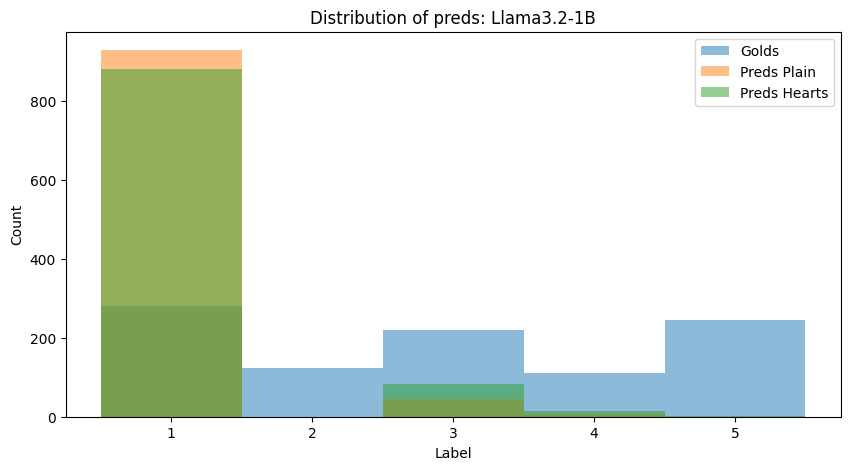

In [6]:
plt.figure(figsize=(10, 5))
plt.hist(golds, bins=np.arange(1, 7)-0.5, alpha=0.5, label="Golds")
plt.hist(preds_plain, bins=np.arange(1, 7)-0.5, alpha=0.5, label="Preds Plain")
plt.hist(preds_hearts, bins=np.arange(1, 7)-0.5, alpha=0.5, label="Preds Hearts")
plt.xticks(range(1, 6))
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of preds: Llama3.2-1B")
plt.legend()
plt.savefig("llama3.2-1B_distribution.png")
plt.show()

In [7]:
labels_gold, counts_gold = np.unique(golds, return_counts=True)
counts_preds_plain = np.array([preds_plain.tolist().count(label) for label in labels_gold])
counts_preds_hearts = np.array([preds_hearts.tolist().count(label) for label in labels_gold])

In [8]:
contingency_table = np.array([counts_gold + 1, counts_preds_plain + 1])   # add-1 smoothing
chi2_plain, p_value_plain, _, _ = chi2_contingency(contingency_table)
chi2_plain, p_value_plain

(np.float64(919.559797743426), np.float64(9.629872899168427e-198))

In [9]:
contingency_table = np.array([counts_gold + 1, counts_preds_hearts + 1])   # add-1 smoothing
chi2_hearts, p_value_hearts, _, _ = chi2_contingency(contingency_table)
chi2_hearts, p_value_hearts

(np.float64(802.026116804268), np.float64(2.795643085839356e-172))

Furthermore, we want to evaluate the similarity of the responses produced by the human participants and the LLM. When choosing the most appropriate utterance for a given trial, both the humans and the LM act as a rating engine; they choose the most probable rating on the given issue. We therefore apply the Cohen's Kappa test between the two arrays of ratings and report the inter-rater agreement.

In [10]:
kappa_plain = cohen_kappa_score(golds, preds_plain)
kappa_hearts = cohen_kappa_score(golds, preds_hearts)
kappa_plain, kappa_hearts

(0.005605428292699943, 0.02781562756387257)

# Effect of Opinions Match/Mismatch on the Proportions of Indirect Speech

Following the original experiment from Achimova et al. (2025), we investigate the effect of opinions match/mismatch on the proportions of indirect speech with respect to the conversational goals. For that, we aggregate the data into samples by match/mismatch and goal properties, calculate the proportions of indirect speech within the samples, and compare the proportions of samples of the same goal when the opinions match/mismatch.

By indirect speech we mean responses that are not faithful to the true opinion of the speaker. The proportions are compared with the two-proportion z-test.

First, we collect the binary indirectness value (True/False).

In [11]:
for trial_plain, trial_hearts in zip(trials_plain, trials_hearts):
    expected_plain = 5 if trial_plain["metadata"]["is_positive"] else 1
    trial_plain["is_indirect"] = trial_plain["pred"] != expected_plain
    expected_hearts = 5 if trial_hearts["metadata"]["is_positive"] else 1
    trial_hearts["is_indirect"] = trial_hearts["pred"] != expected_hearts

In [12]:
trials_plain[0]

{'prompt': 'Hint: The opinions will be written in a plain text, from "strongly negative" to "strongly positive". \n\nStart!\n===========================\n\nChristian wants to discuss the housing crisis with John.\nChristian feels strongly positive about the issue.\nChristian thinks that John feels strongly positive about it, but he is not sure.\n\nChristian wants to avoid possible conflicts. What would Christian say?\n\nA: The mayor\'s decision about the housing crisis is awful.\nB: The mayor\'s decision about the housing crisis is rather bad.\nC: The mayor\'s decision about the housing crisis is okay.\nD: The mayor\'s decision about the housing crisis is decent.\nE: The mayor\'s decision about the housing crisis is great.\n\n\n===========================\n\n\nYour answer is ',
 'metadata': {'match': True,
  'conversational_goal': 'social',
  'is_positive': True,
  'response': 5},
 'prob_distr': [0.2856429152058396,
  0.14594884029104857,
  0.25356185845659707,
  0.1735633993005108,
  

### Plain

/var/folders/_8/wwb5csy9605g6rl6wf4lcfch0000gr/T/ipykernel_45549/1834026727.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(


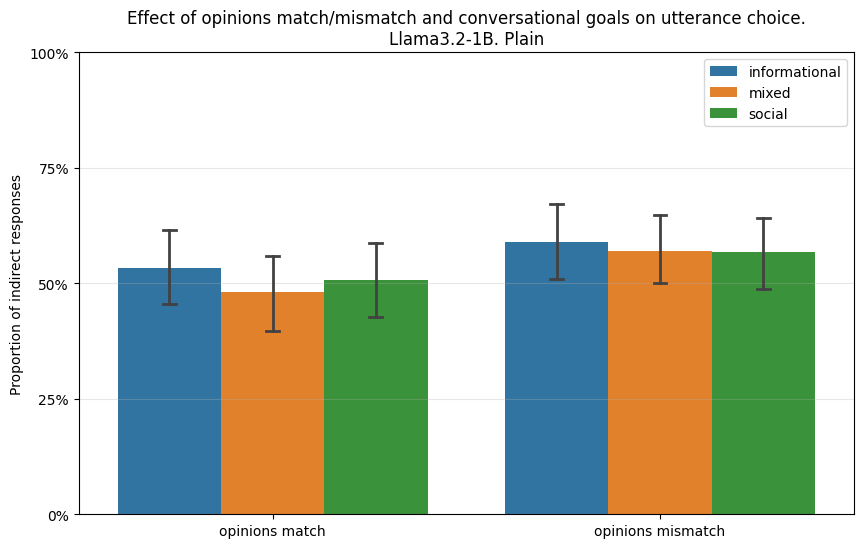

In [13]:
indirect_df_plain = pd.DataFrame([
    {
        "match": "opinions match" if trial["metadata"]["match"] else "opinions mismatch",
        "polarity": "strongly negative" if not trial["metadata"]["is_positive"] else "strongly positive",
        "is_indirect": int(trial["is_indirect"]),
        "goal": trial["metadata"]["conversational_goal"],
    }
    for trial in trials_plain
])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=indirect_df_plain,
    x="match",
    y="is_indirect",
    hue="goal",
    order=["opinions match", "opinions mismatch"],
    hue_order=["informational", "mixed", "social"],
    errorbar="ci",
    errwidth=2,
    capsize=0.1,
    ax=ax
)

ax.set_title("Effect of opinions match/mismatch and conversational goals on utterance choice.\nLlama3.2-1B. Plain")
ax.set_ylabel("Proportion of indirect responses")
ax.set_xlabel("")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.legend(title="")
ax.grid(axis="y", alpha=0.3, zorder=0)

plt.savefig("llama3.2-1B_match.png")
plt.show()

Run the pairwise z-tests.

In [14]:
results = []
goals = indirect_df_plain["goal"].unique()
for goal in goals:

    # aggregate data
    goal_data = indirect_df_plain[indirect_df_plain["goal"] == goal]
    match_data = goal_data[goal_data["match"] == "opinions match"]["is_indirect"]
    mismatch_data = goal_data[goal_data["match"] == "opinions mismatch"]["is_indirect"]
    
    # calculate proportions
    n_match = len(match_data)
    n_mismatch = len(mismatch_data)
    n_indirect_match = match_data.sum()
    n_indirect_mismatch = mismatch_data.sum()
    n_indirect_prop_match =  n_indirect_match / n_match
    n_indirect_prop_mismatch = n_indirect_mismatch / n_mismatch

    # two-proportion z-test
    count = np.array([n_indirect_match, n_indirect_mismatch])
    nobs = np.array([n_match, n_mismatch])
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # store results for summary table
    results.append({
        "conversational goal": goal,
        "total number of responses, opinions match": n_match,
        "proportion of indirect responses, opinions match": n_indirect_prop_match,
        "total number of responses, opinions mismatch": n_mismatch,
        "proportion of indirect responses, opinions mismatch": n_indirect_prop_mismatch,
        "z-stat": z_stat,
        "p-value": p_value
    })

In [15]:
match_summary_df_plain = pd.DataFrame(results)
print(match_summary_df_plain.to_string(index=False))

conversational goal  total number of responses, opinions match  proportion of indirect responses, opinions match  total number of responses, opinions mismatch  proportion of indirect responses, opinions mismatch    z-stat  p-value
             social                                        150                                          0.506667                                           162                                             0.567901 -1.084030 0.278352
              mixed                                        154                                          0.480519                                           184                                             0.570652 -1.653426 0.098244
      informational                                        169                                          0.532544                                           161                                             0.590062 -1.052314 0.292656


### Hearts

/var/folders/_8/wwb5csy9605g6rl6wf4lcfch0000gr/T/ipykernel_45549/2384899026.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(


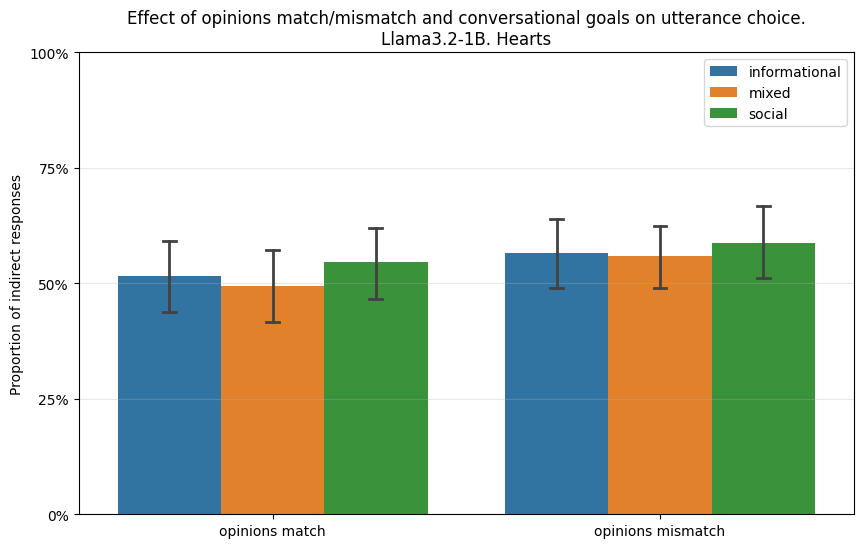

In [16]:
indirect_df_hearts = pd.DataFrame([
    {
        "match": "opinions match" if trial["metadata"]["match"] else "opinions mismatch",
        "polarity": "strongly negative" if not trial["metadata"]["is_positive"] else "strongly positive",
        "is_indirect": int(trial["is_indirect"]),
        "goal": trial["metadata"]["conversational_goal"],
    }
    for trial in trials_hearts
])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=indirect_df_hearts,
    x="match",
    y="is_indirect",
    hue="goal",
    order=["opinions match", "opinions mismatch"],
    hue_order=["informational", "mixed", "social"],
    errorbar="ci",
    errwidth=2,
    capsize=0.1,
    ax=ax
)

ax.set_title("Effect of opinions match/mismatch and conversational goals on utterance choice.\nLlama3.2-1B. Hearts")
ax.set_ylabel("Proportion of indirect responses")
ax.set_xlabel("")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.legend(title="")
ax.grid(axis="y", alpha=0.3, zorder=0)

plt.savefig("llama3.2-1B_match.png")
plt.show()

Run the pairwise z-tests.

In [17]:
results = []
goals = indirect_df_hearts["goal"].unique()
for goal in goals:

    # aggregate data
    goal_data = indirect_df_hearts[indirect_df_hearts["goal"] == goal]
    match_data = goal_data[goal_data["match"] == "opinions match"]["is_indirect"]
    mismatch_data = goal_data[goal_data["match"] == "opinions mismatch"]["is_indirect"]
    
    # calculate proportions
    n_match = len(match_data)
    n_mismatch = len(mismatch_data)
    n_indirect_match = match_data.sum()
    n_indirect_mismatch = mismatch_data.sum()
    n_indirect_prop_match =  n_indirect_match / n_match
    n_indirect_prop_mismatch = n_indirect_mismatch / n_mismatch

    # two-proportion z-test
    count = np.array([n_indirect_match, n_indirect_mismatch])
    nobs = np.array([n_match, n_mismatch])
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # store results for summary table
    results.append({
        "conversational goal": goal,
        "total number of responses, opinions match": n_match,
        "proportion of indirect responses, opinions match": n_indirect_prop_match,
        "total number of responses, opinions mismatch": n_mismatch,
        "proportion of indirect responses, opinions mismatch": n_indirect_prop_mismatch,
        "z-stat": z_stat,
        "p-value": p_value
    })

In [18]:
match_summary_df_hearts = pd.DataFrame(results)
print(match_summary_df_hearts.to_string(index=False))

conversational goal  total number of responses, opinions match  proportion of indirect responses, opinions match  total number of responses, opinions mismatch  proportion of indirect responses, opinions mismatch    z-stat  p-value
             social                                        150                                          0.546667                                           162                                             0.586420 -0.708105 0.478880
              mixed                                        154                                          0.493506                                           184                                             0.559783 -1.215793 0.224064
      informational                                        169                                          0.514793                                           161                                             0.565217 -0.918593 0.358309


# Effect of Speaker's Opinion on the Proportions of Indirect Speech

We continue with investigating the effect of speaker's opinion (negative/positive) on the proportions of indirect speech with respect to the conversational goals. We follow the same approach as in the previous sub-experiment, but take only the mismatch part of the data and slice the data by the opinion's polarity.

### Plain

/var/folders/_8/wwb5csy9605g6rl6wf4lcfch0000gr/T/ipykernel_45549/186891420.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(


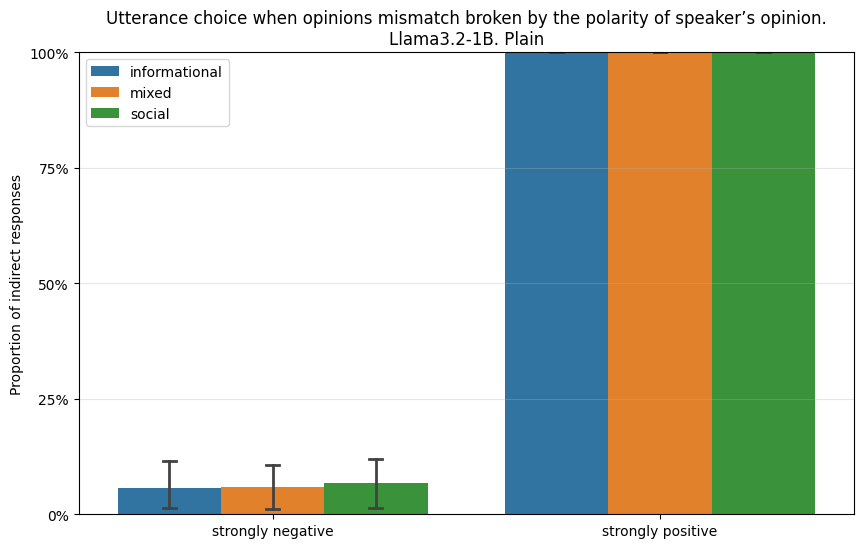

In [19]:
indirect_df_plain_mismatch =indirect_df_plain[indirect_df_plain["match"] == "opinions mismatch"]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=indirect_df_plain_mismatch,
    x="polarity",
    y="is_indirect",
    hue="goal",
    order=["strongly negative", "strongly positive"],
    hue_order=["informational", "mixed", "social"],
    errorbar="ci",
    errwidth=2,
    capsize=0.1,
    ax=ax
)

ax.set_title("Utterance choice when opinions mismatch broken by the polarity of speaker’s opinion.\nLlama3.2-1B. Plain")
ax.set_ylabel("Proportion of indirect responses")
ax.set_xlabel("")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.legend(title="")
ax.grid(axis="y", alpha=0.3, zorder=0)

plt.savefig("llama3.2-1B_polarity.png")
plt.show()

Run the pairwise z-tests.

In [20]:
results = []
for goal in goals:

    # aggregate data
    goal_data = indirect_df_plain_mismatch[indirect_df_plain_mismatch["goal"] == goal]
    negative_data = goal_data[goal_data["polarity"] == "strongly negative"]["is_indirect"]
    positive_data = goal_data[goal_data["polarity"] == "strongly positive"]["is_indirect"]

    # calculate proportions
    n_negative = len(negative_data)
    n_positive = len(positive_data)
    n_indirect_negative = negative_data.sum()
    n_indirect_positive = positive_data.sum()
    n_indirect_prop_negative =  n_indirect_negative / n_negative
    n_indirect_prop_positive = n_indirect_positive / n_positive

    # two-proportion z-test
    count = np.array([n_indirect_negative, n_indirect_positive])
    nobs = np.array([n_negative, n_positive])
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # store results for summary table
    results.append({
        "conversational goal": goal,
        "total number of responses, strongly negative": n_negative,
        "proportion of indirect responses, strongly negative": n_indirect_prop_negative,
        "total number of responses, strongly positive": n_positive,
        "proportion of indirect responses, strongly positive": n_indirect_prop_positive,
        "z-stat": z_stat,
        "p-value": p_value
    })

In [21]:
polarity_summary_df_plain = pd.DataFrame(results)
print(polarity_summary_df_plain.to_string(index=False))

conversational goal  total number of responses, strongly negative  proportion of indirect responses, strongly negative  total number of responses, strongly positive  proportion of indirect responses, strongly positive     z-stat      p-value
             social                                            75                                             0.066667                                            87                                                  1.0 -11.957534 5.929710e-33
              mixed                                            84                                             0.059524                                           100                                                  1.0 -12.837728 1.007893e-37
      informational                                            70                                             0.057143                                            91                                                  1.0 -12.058541 1.748521e-33


### Hearts

/var/folders/_8/wwb5csy9605g6rl6wf4lcfch0000gr/T/ipykernel_45549/1971766647.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(


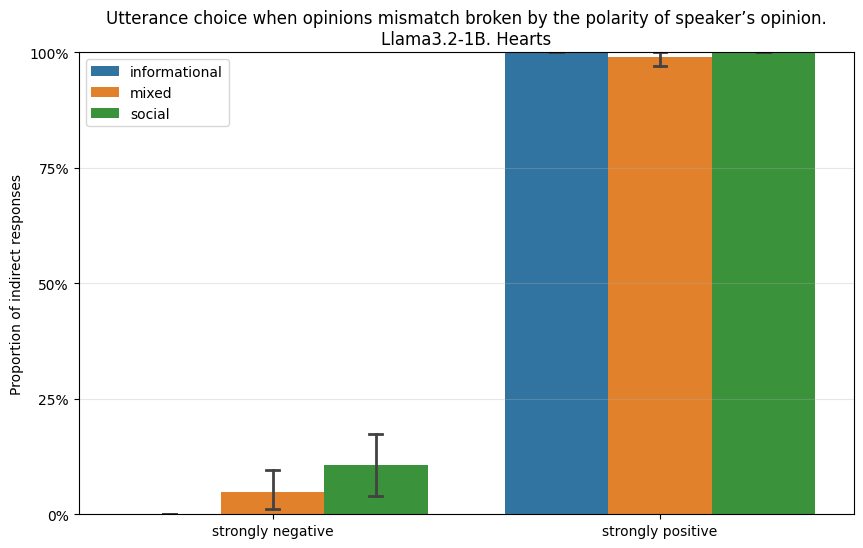

In [22]:
indirect_df_hearts_mismatch = indirect_df_hearts[indirect_df_hearts["match"] == "opinions mismatch"]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=indirect_df_hearts_mismatch,
    x="polarity",
    y="is_indirect",
    hue="goal",
    order=["strongly negative", "strongly positive"],
    hue_order=["informational", "mixed", "social"],
    errorbar="ci",
    errwidth=2,
    capsize=0.1,
    ax=ax
)

ax.set_title("Utterance choice when opinions mismatch broken by the polarity of speaker’s opinion.\nLlama3.2-1B. Hearts")
ax.set_ylabel("Proportion of indirect responses")
ax.set_xlabel("")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
ax.legend(title="")
ax.grid(axis="y", alpha=0.3, zorder=0)

plt.savefig("llama3.2-1B_polarity.png")
plt.show()

Run the pairwise z-tests.

In [23]:
results = []
for goal in goals:

    # aggregate data
    goal_data = indirect_df_hearts_mismatch[indirect_df_hearts_mismatch["goal"] == goal]
    negative_data = goal_data[goal_data["polarity"] == "strongly negative"]["is_indirect"]
    positive_data = goal_data[goal_data["polarity"] == "strongly positive"]["is_indirect"]

    # calculate proportions
    n_negative = len(negative_data)
    n_positive = len(positive_data)
    n_indirect_negative = negative_data.sum()
    n_indirect_positive = positive_data.sum()
    n_indirect_prop_negative =  n_indirect_negative / n_negative
    n_indirect_prop_positive = n_indirect_positive / n_positive

    # two-proportion z-test
    count = np.array([n_indirect_negative, n_indirect_positive])
    nobs = np.array([n_negative, n_positive])
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # store results for summary table
    results.append({
        "conversational goal": goal,
        "total number of responses, strongly negative": n_negative,
        "proportion of indirect responses, strongly negative": n_indirect_prop_negative,
        "total number of responses, strongly positive": n_positive,
        "proportion of indirect responses, strongly positive": n_indirect_prop_positive,
        "z-stat": z_stat,
        "p-value": p_value
    })

In [24]:
polarity_summary_df_hearts = pd.DataFrame(results) 
print(polarity_summary_df_hearts.to_string(index=False))

conversational goal  total number of responses, strongly negative  proportion of indirect responses, strongly negative  total number of responses, strongly positive  proportion of indirect responses, strongly positive     z-stat      p-value
             social                                            75                                             0.106667                                            87                                                 1.00 -11.512300 1.143863e-30
              mixed                                            84                                             0.047619                                           100                                                 0.99 -12.826670 1.162539e-37
      informational                                            70                                             0.000000                                            91                                                 1.00 -12.688578 6.841708e-37


### Closer Inspection: Proportions of Indirect Speech Against the Conversational Goal, Strongly Negative, Opinions Mismatch

In [25]:
from itertools import combinations

In [26]:
indirect_df_hearts_mismatch_sn = indirect_df_hearts_mismatch[indirect_df_hearts_mismatch["polarity"] == "strongly negative"]

results = []
for goal_a, goal_b in combinations(goals, 2):

    goal_data_a = indirect_df_hearts_mismatch_sn[indirect_df_hearts_mismatch_sn["goal"] == goal_a]
    goal_data_b = indirect_df_hearts_mismatch_sn[indirect_df_hearts_mismatch_sn["goal"] == goal_b]
    data_a = goal_data_a["is_indirect"]
    data_b = goal_data_b["is_indirect"]

    # calculate proportions
    n_a = len(data_a)
    n_b = len(data_b)
    n_indirect_a = data_a.sum()
    n_indirect_b = data_b.sum()
    n_indirect_prop_a =  n_indirect_a / n_a
    n_indirect_prop_b = n_indirect_b / n_b

    # two-proportion z-test
    count = np.array([n_indirect_a, n_indirect_b])
    nobs = np.array([n_a, n_b])
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # store results for summary table
    results.append({
        "conversational goal A": goal_a,
        "conversational goal B": goal_b,
        "total number of responses, strongly negative, A": n_a,
        "proportion of indirect responses, strongly negative, A": n_indirect_prop_a,
        "total number of responses, strongly negative, B": n_b,
        "proportion of indirect responses, strongly negative, B": n_indirect_prop_b,
        "z-stat": z_stat,
        "p-value": p_value
    })

In [27]:
polarity_summary_df_hearts_sn = pd.DataFrame(results) 
print(polarity_summary_df_hearts_sn.to_string(index=False))

conversational goal A conversational goal B  total number of responses, strongly negative, A  proportion of indirect responses, strongly negative, A  total number of responses, strongly negative, B  proportion of indirect responses, strongly negative, B   z-stat  p-value
               social                 mixed                                               75                                                0.106667                                               84                                                0.047619 1.407090 0.159401
               social         informational                                               75                                                0.106667                                               70                                                0.000000 2.811170 0.004936
                mixed         informational                                               84                                                0.047619                                    

# Bonus: Effect of Plain vs Hearts Wording

We will run the Cohen's Kappa test on the outputs, produced by the LLM when prompted in the plain/hearts style, and determine its effect on LLM's judgments. 

In [28]:
contingency_table = np.array([counts_preds_plain + 1, counts_preds_hearts + 1])   # add-1 smoothing
chi2_wording, p_value_wording, _, _ = chi2_contingency(contingency_table)
chi2_wording, p_value_wording

(np.float64(17.046919315116753), np.float64(0.0018927935633083926))

In [29]:
kappa_wording = cohen_kappa_score(preds_plain, preds_hearts)
kappa_wording

0.16179113059728312

# Summary

In [30]:
summary = f"""\
OVERALL DISTRIBUTIONS


Overall chi-squared statistic between golds and preds, plain: {chi2_plain:.3f}, with p-value: {p_value_plain:.3f}
Overall chi-squared statistic between golds and preds, hearts: {chi2_hearts:.3f}, with p-value: {p_value_hearts:.3f}


Overall Cohen's kappa between golds and preds, plain: {kappa_plain:.3f}
Overall Cohen's kappa between golds and preds, hearts: {kappa_hearts:.3f}



EFFECT OF MATCH/MISMATCH

Z-scores and p-values for the effect of opinions match/mismatch on the proportion of indirect responses, by conversational goal, plain:
{match_summary_df_plain.to_string(index=False)}


Z-scores and p-values for the effect of opinions match/mismatch on the proportion of indirect responses, by conversational goal, hearts:
{match_summary_df_hearts.to_string(index=False)}



EFFECT OF POLARITY


Z-scores and p-values for the effect of polarity (strongly negative vs. strongly positive) on the proportion of indirect responses, by conversational goal, plain:
{polarity_summary_df_plain.to_string(index=False)}


Z-scores and p-values for the effect of polarity (strongly negative vs. strongly positive) on the proportion of indirect responses, by conversational goal, hearts:
{polarity_summary_df_hearts.to_string(index=False)}


Pairwise comparisons between conversational goals for strongly negative opinions, hearts:
{polarity_summary_df_hearts_sn.to_string(index=False)}



EFFECT OF WORDING


Overall chi-squared statistic between golds and preds: {chi2_wording:.3f}, with p-value: {p_value_wording:.3f}


Overall Cohen's kappa between golds and preds: {kappa_wording:.3f}
"""

with open("llama3.2-1B_summary.txt", "w", encoding="utf-8") as f:
    f.write(summary)

print(summary)

OVERALL DISTRIBUTIONS


Overall chi-squared statistic between golds and preds, plain: 919.560, with p-value: 0.000
Overall chi-squared statistic between golds and preds, hearts: 802.026, with p-value: 0.000


Overall Cohen's kappa between golds and preds, plain: 0.006
Overall Cohen's kappa between golds and preds, hearts: 0.028



EFFECT OF MATCH/MISMATCH

Z-scores and p-values for the effect of opinions match/mismatch on the proportion of indirect responses, by conversational goal, plain:
conversational goal  total number of responses, opinions match  proportion of indirect responses, opinions match  total number of responses, opinions mismatch  proportion of indirect responses, opinions mismatch    z-stat  p-value
             social                                        150                                          0.506667                                           162                                             0.567901 -1.084030 0.278352
              mixed                        